In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import datetime 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [3]:
file = '/home/2017LMSOM2/e21608618/Téléchargements/ncep_msl_1948to2017.nc'
data = Dataset(file,'r',format='NETCDF4')

lon = np.array(data.variables['longitude'][:])
lat = np.array(data.variables['latitude'][:])
t = np.array(data.variables['time'][:])
p = np.array(data.variables['msl'][:])/100
pp = p-np.mean(p, axis=0)

In [4]:
data.variables['time']
dateref = datetime.datetime.strptime('1948-1-1',"%Y-%m-%d")
time = []
for i in range(0,len(t)):
    time.append(dateref + datetime.timedelta(hours = int(t[i])))
time = np.array(time)

LON, LAT = np.meshgrid(lon,lat)

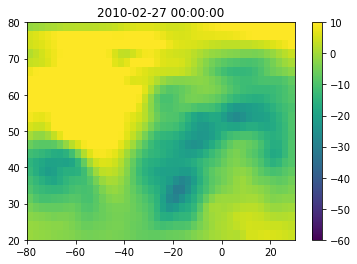

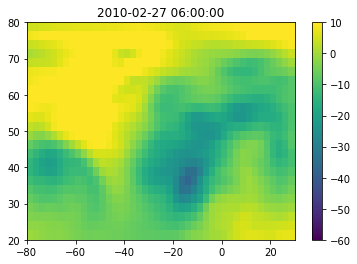

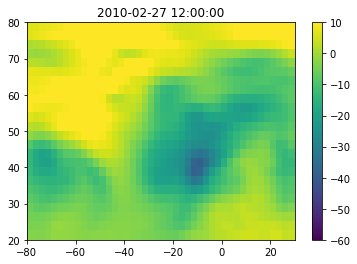

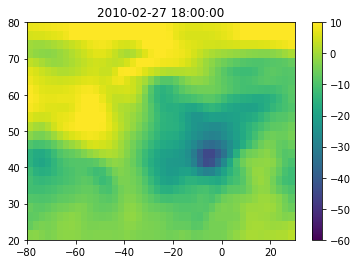

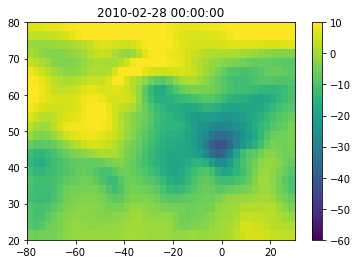

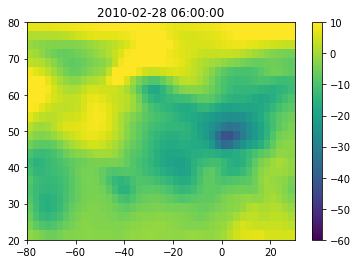

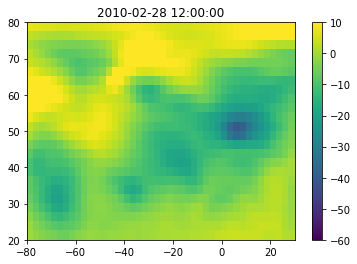

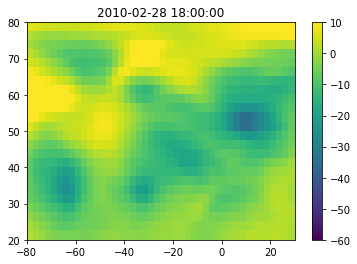

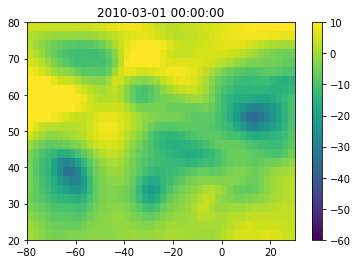

In [21]:
#Permet d'afficher l'avolution des pression durant une période définie

datedebut = datetime.datetime.strptime('2010-2-27',"%Y-%m-%d")
datefin = datetime.datetime.strptime('2010-3-1',"%Y-%m-%d")
ind = np.where((time>=datedebut)&(time<=datefin))[0]

for k in ind:
     
    plt.figure()
    plt.pcolormesh(LON,LAT,pp[k])
    plt.colorbar()
    plt.clim([-60,10])
    plt.title(time[k])

In [8]:
#Base d'apprentissage 
from random import randint

k_good = [75946,75947,75948,75949,74492,83310,83311,86269,86270,86271,89212,89213,89214,89215,89216,89217,89218,89219,89220]
k_rand=[randint(0,len(t)) for i in range(0,30)]
k_ind = np.append(k_good,k_rand)

xc_good = np.zeros(np.shape(k_good))
yc_good = np.zeros(np.shape(k_good))



for i in range(0,len(k_good)):
    k=k_good[i]
    xc_good[i]=(np.where(pp[k]==np.nanmin(pp[k]))[0][0])
    yc_good[i]=(np.where(pp[k]==np.nanmin(pp[k]))[1][0])


xc_rand=[randint(6,len(lat)-6) for i in range(0,30)]
yc_rand=[randint(6,len(lon)-6) for i in range(0,30)]


xc = np.append(xc_good,xc_rand)
yc = np.append(yc_good,yc_rand)

flag = np.zeros(len(k_good)+len(k_rand))
flag[0:len(k_good)]=1

dt=6

learn=np.zeros([len(k_good)+len(k_rand),(2*dt)**2])


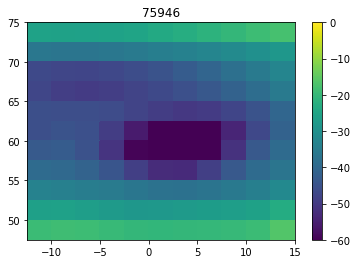

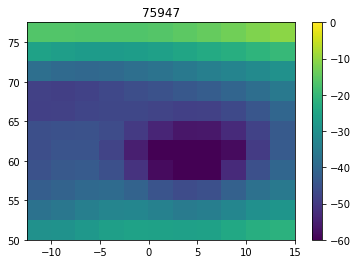

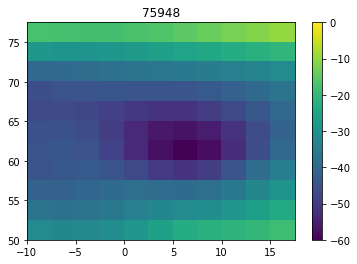

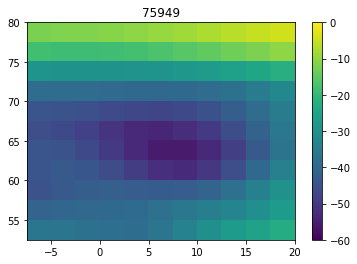

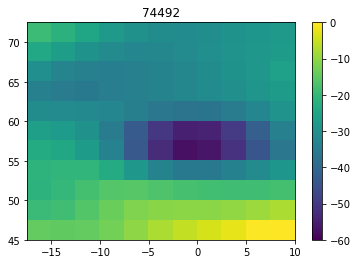

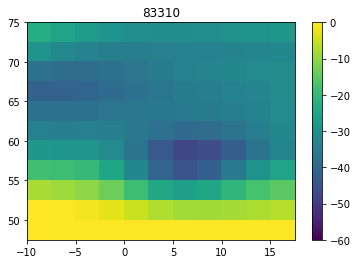

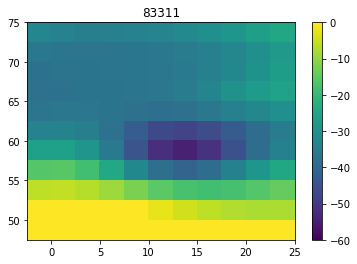

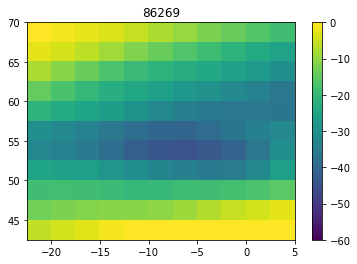

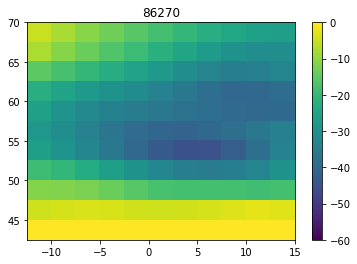

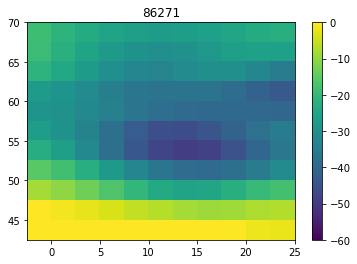

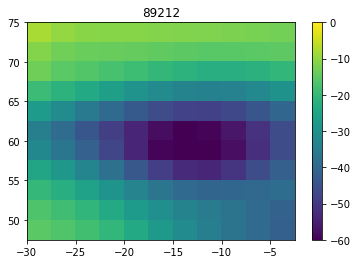

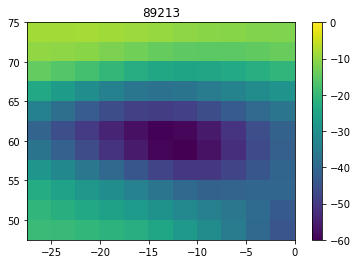

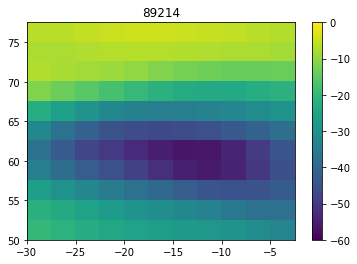

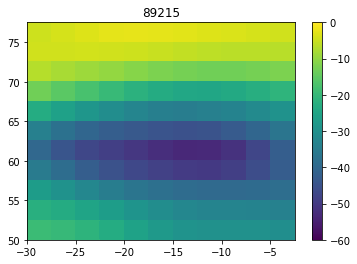

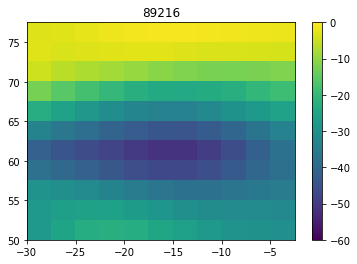

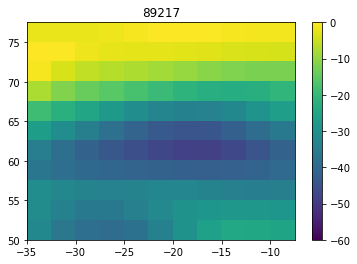

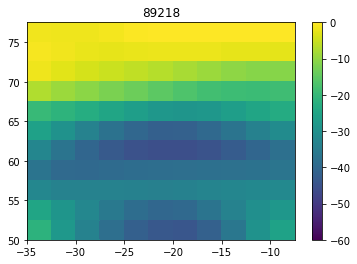

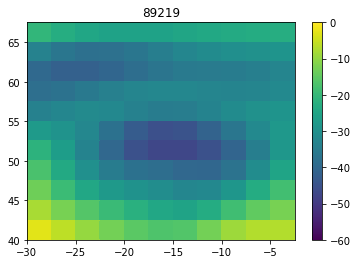

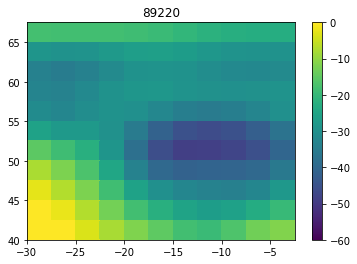

In [9]:
for i in range(0,len(k_good)): # Plot des bonnes vignettes pour l'apprentissage
    k=k_good[i]
    plt.figure()    
    plt.pcolormesh(LON[int(xc_good[i])-dt:int(xc_good[i])+dt,int(yc_good[i])-dt:int(yc_good[i])+dt],LAT[int(xc_good[i])-dt:int(xc_good[i])+dt,int(yc_good[i])-dt:int(yc_good[i])+dt],pp[k,int(xc_good[i])-dt:int(xc_good[i])+dt,int(yc_good[i])-dt:int(yc_good[i])+dt])
    plt.clim([-60,0])
    plt.colorbar() 
    plt.title(k)

/opt/linux/anaconda3/4.4.0/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


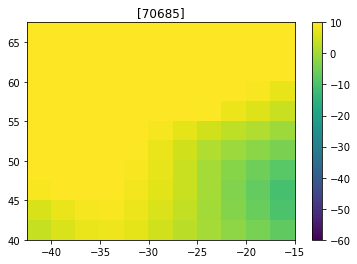

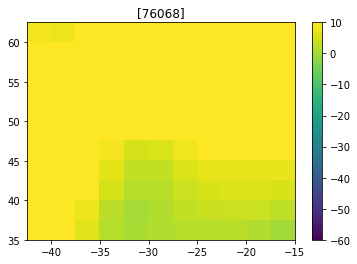

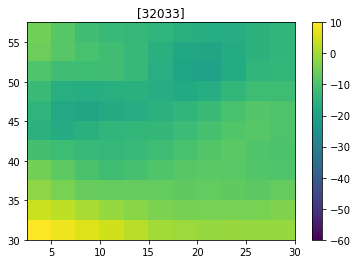

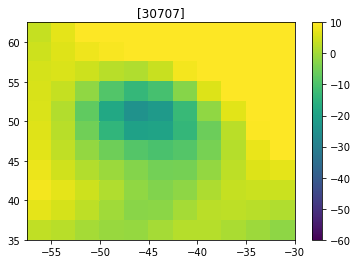

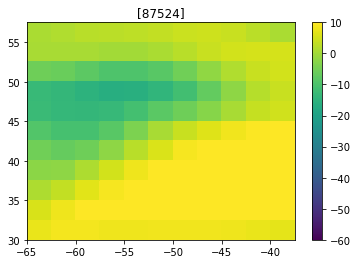

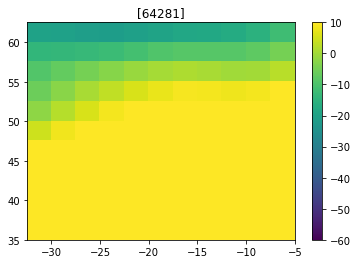

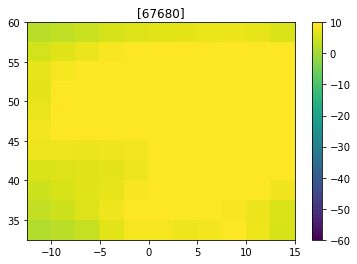

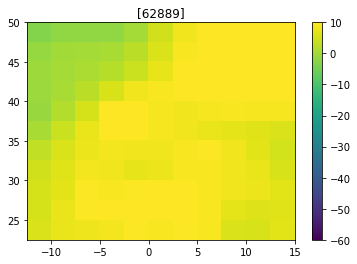

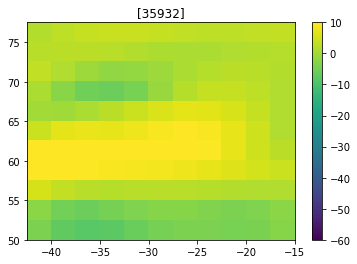

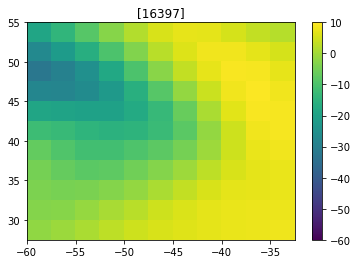

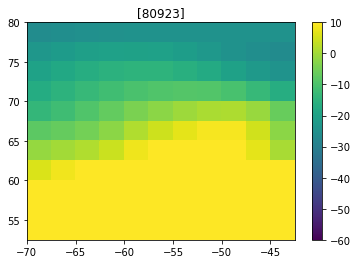

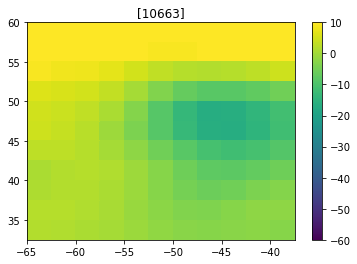

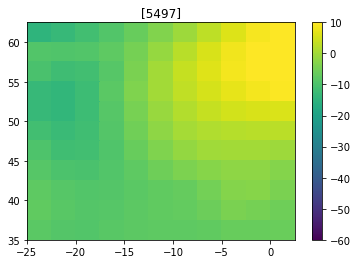

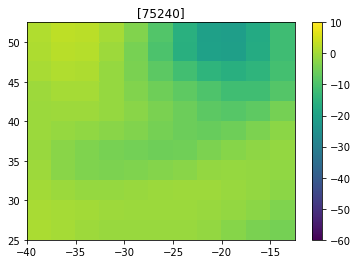

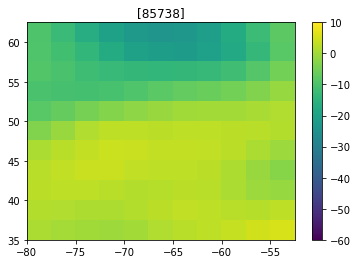

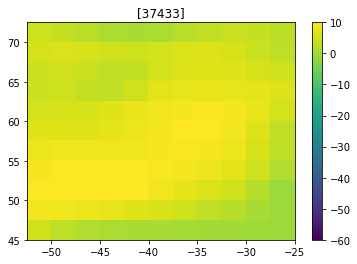

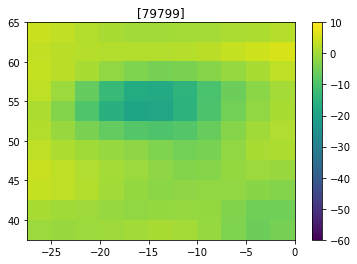

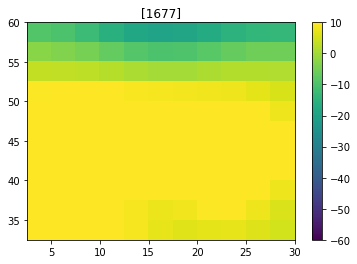

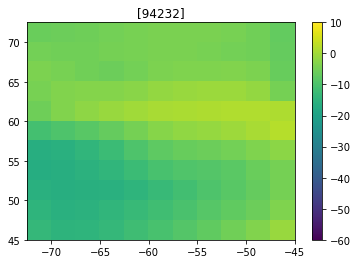

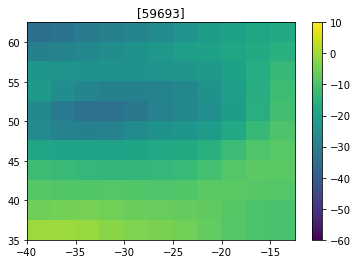

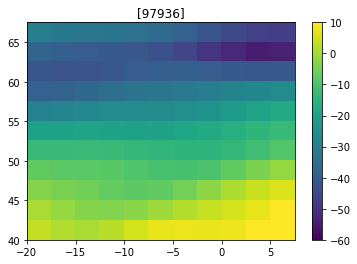

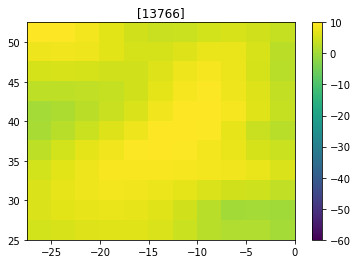

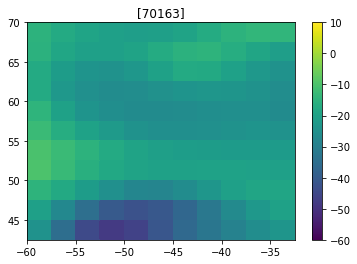

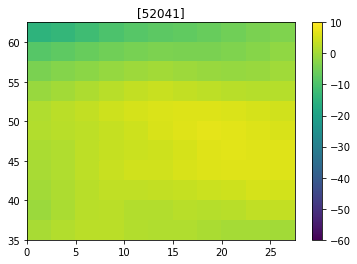

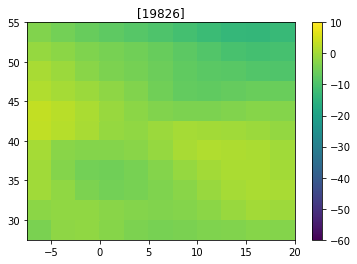

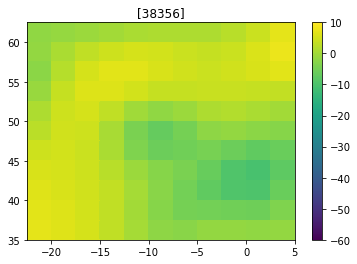

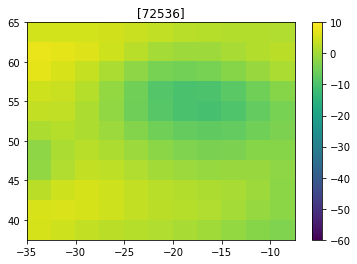

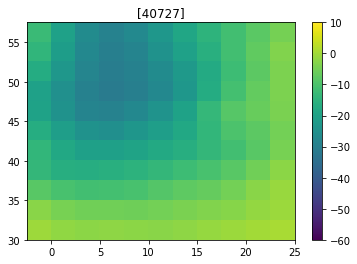

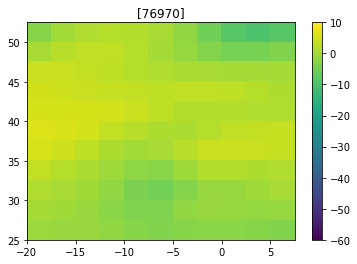

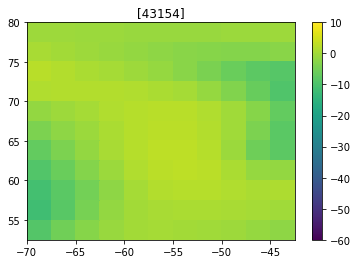

In [12]:
# Plot des vignettes aléatoires (flag = 0 )
import numpy.ma as ma
for i in range(0,len(k_rand)):
    k = [k_rand[i]]
    mask = ma.masked_where(np.isnan(pp[k]),pp[k]) 
    plt.figure()
    plt.pcolormesh(LON[int(xc_rand[i])-dt:int(xc_rand[i])+dt,int(yc_rand[i])-dt:int(yc_rand[i])+dt],LAT[int(xc_rand[i])-dt:int(xc_rand[i])+dt,int(yc_rand[i])-dt:int(yc_rand[i])+dt],mask[0,int(xc_rand[i])-dt:int(xc_rand[i])+dt,int(yc_rand[i])-dt:int(yc_rand[i])+dt])
    plt.colorbar() 
    plt.clim([-60,10])
    plt.title(k)

In [13]:
#On remplit la matrice d'apprentissage avec des images ravellées

for i in range(0,len(k_ind)):
    k=k_ind[i]
    learn[i] = np.ravel(pp[k,int(xc[i])-dt:int(xc[i])+dt,int(yc[i])-dt:int(yc[i])+dt])    

In [14]:
# Split test (apprentissage/test) sur notre echantillon 

learn_train, learn_test, flag_train,flag_test = train_test_split(learn, flag, test_size=0.33, random_state=42)

In [15]:
clf = ExtraTreesClassifier(n_estimators = 100, max_leaf_nodes = 1000, criterion = 'gini',n_jobs=-1)
clf = clf.fit(learn_train,flag_train)
flag_pred = clf.predict(learn_test)
print('Score :', clf.score(learn_test,flag_test))
print('Confusion Maxtrix : \n', confusion_matrix(flag_test,flag_pred))

Score : 1.0
Confusion Maxtrix : 
 [[10  0]
 [ 0  7]]


In [22]:
# Maintenant on test avec notre jeu de donnée: on choisit un jour où l'on sait qu'il y a eu une tempête (23 janv 90 => k =61464 )
k=61464

# Fenêtre glissante:
X = []
for i in range(dt,len(lat)-dt):
    for j in range(dt, len(lon)-dt):
        data = pp[k,i-dt:i+dt,j-dt:j+dt]
        X.append(np.ravel(data)) 

X = np.array(X)



In [17]:
# prediction
X_predic = clf.predict(X)

/opt/linux/anaconda3/4.4.0/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


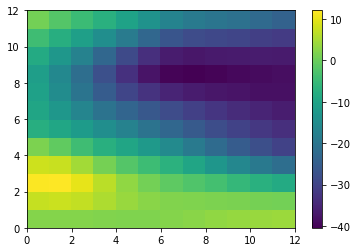

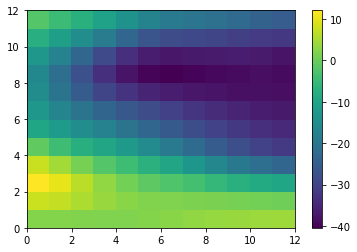

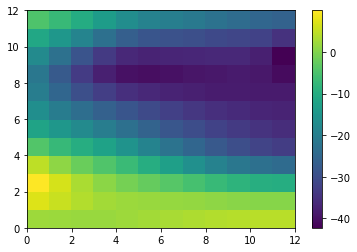

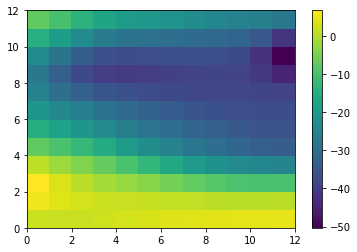

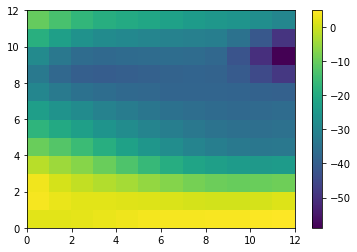

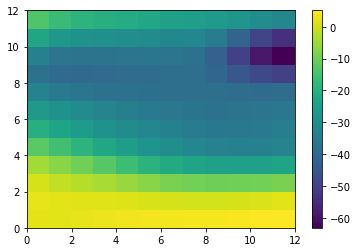

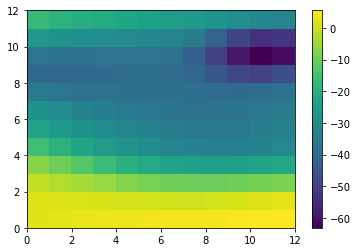

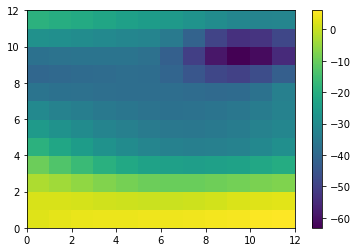

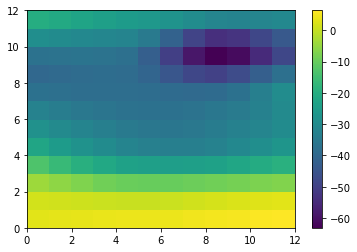

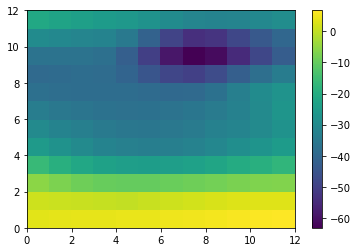

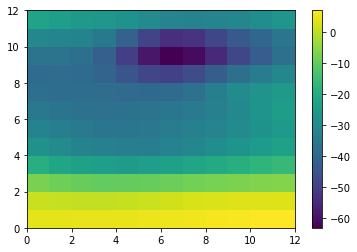

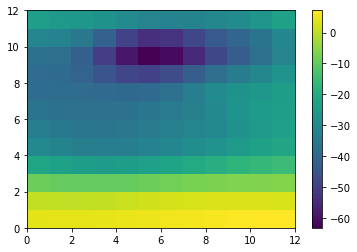

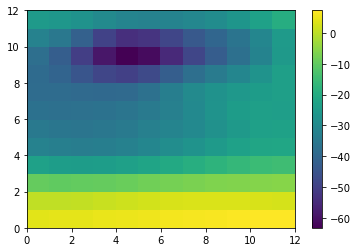

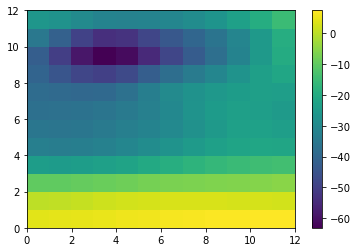

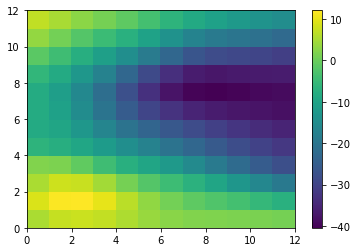

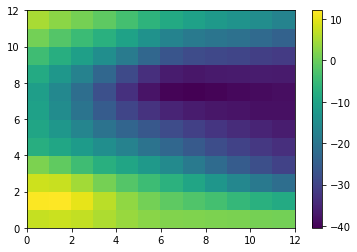

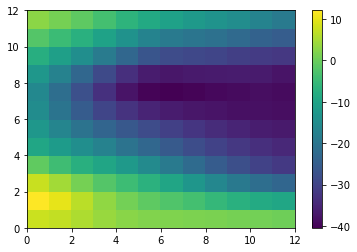

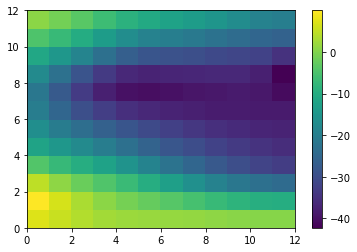

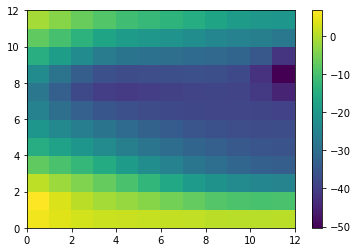

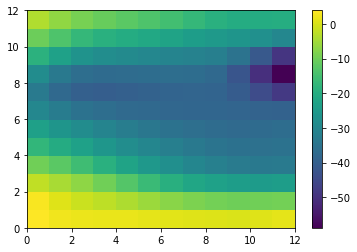

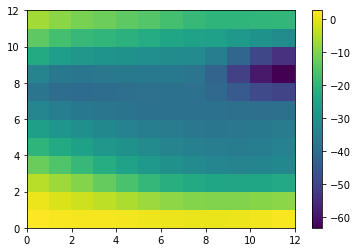

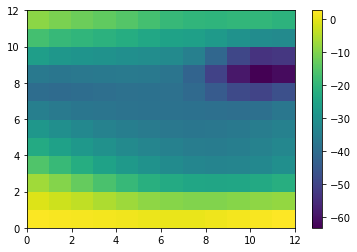

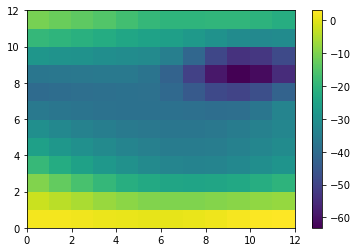

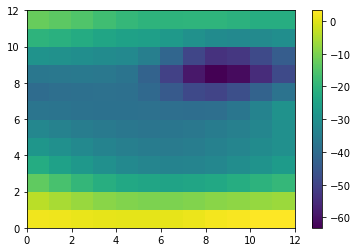

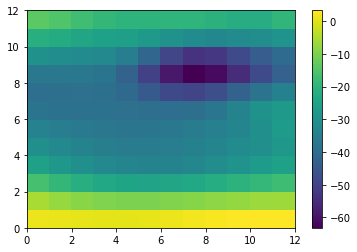

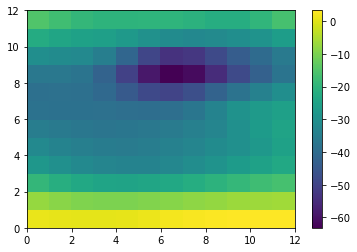

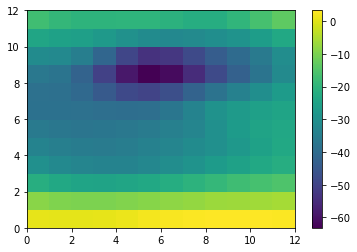

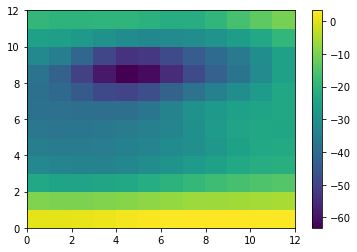

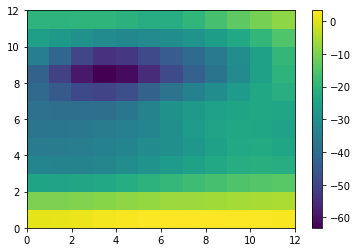

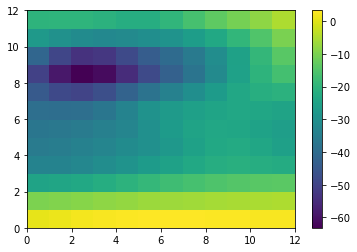

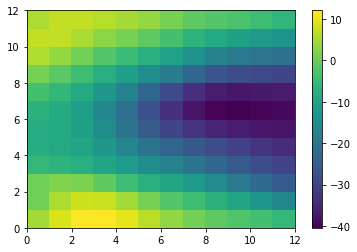

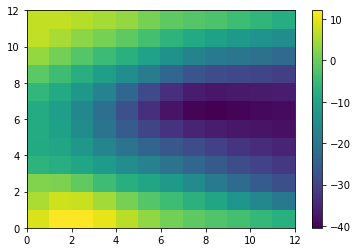

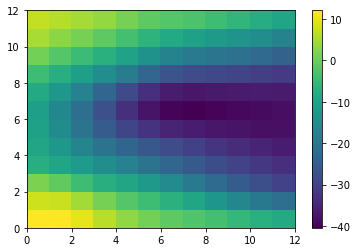

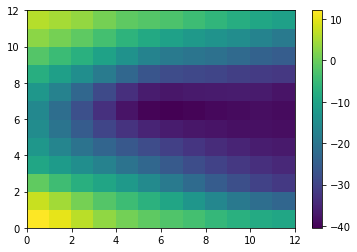

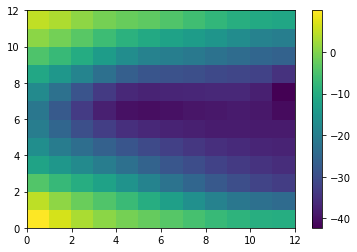

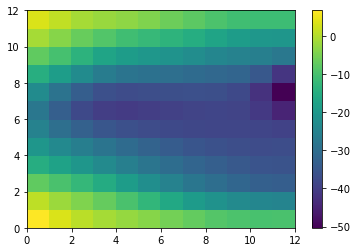

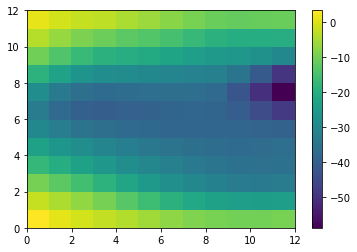

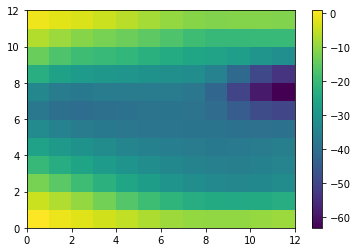

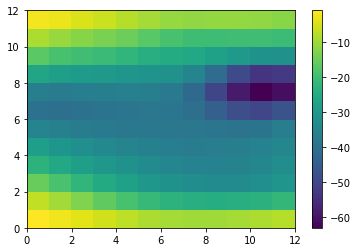

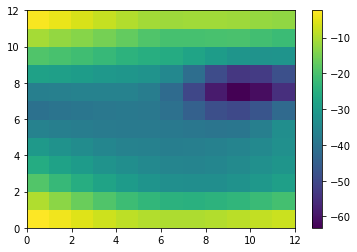

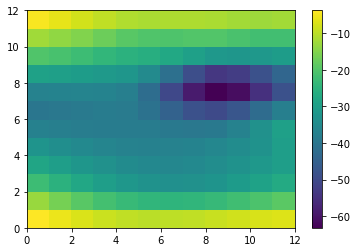

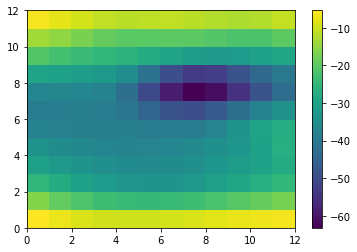

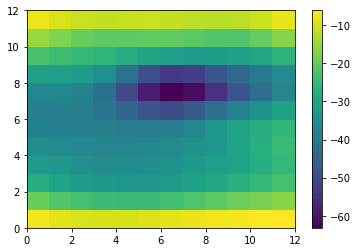

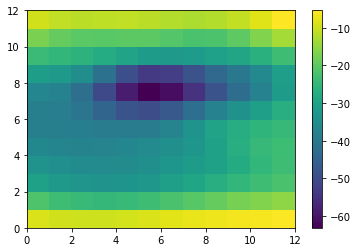

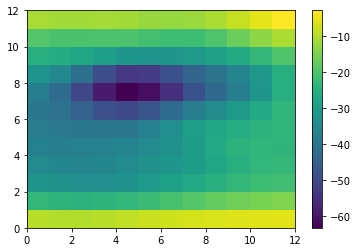

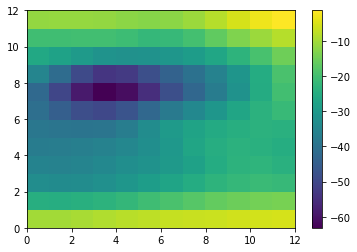

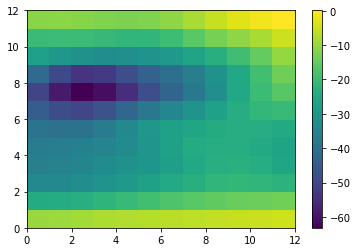

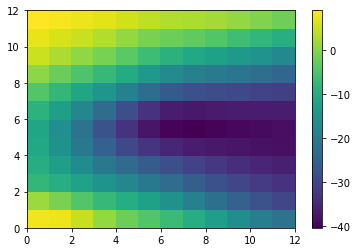

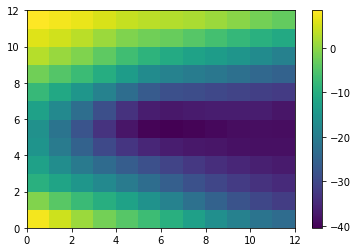

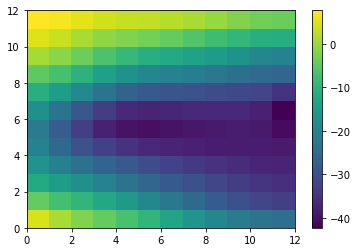

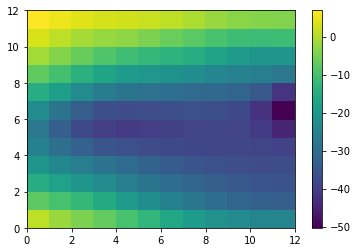

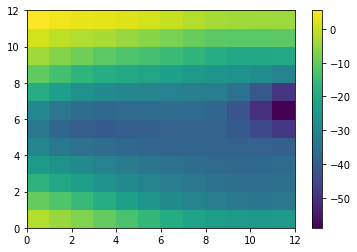

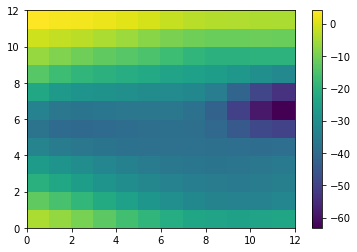

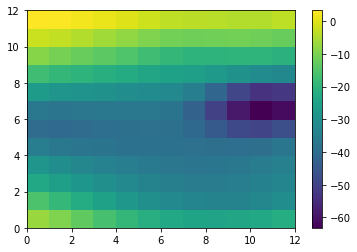

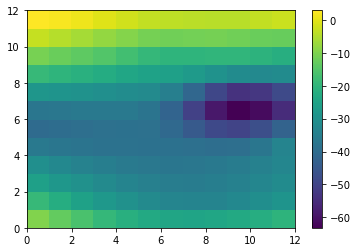

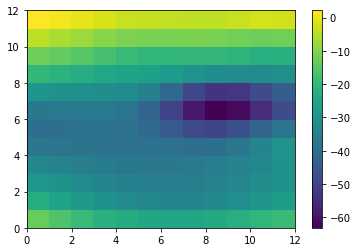

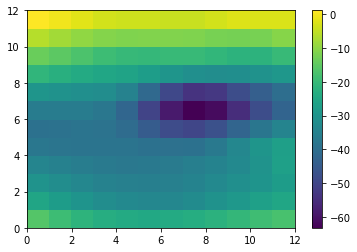

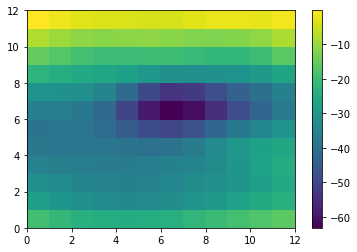

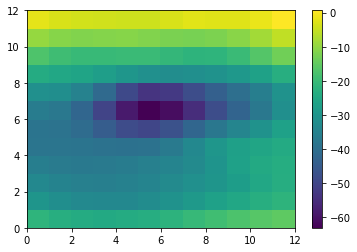

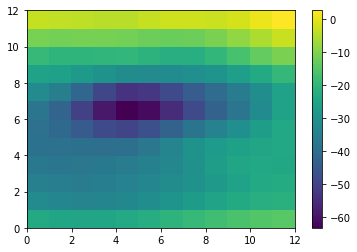

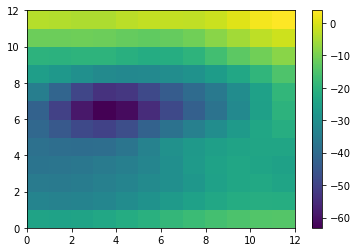

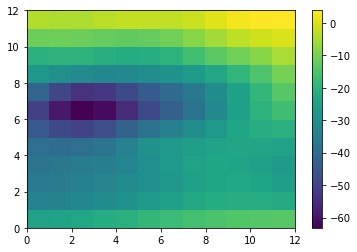

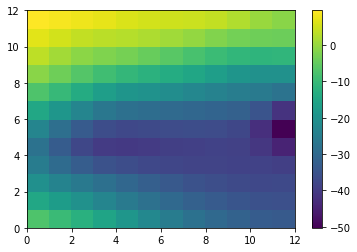

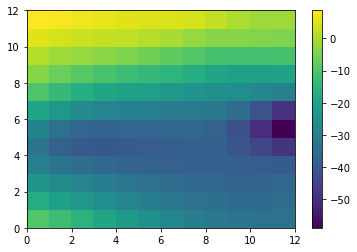

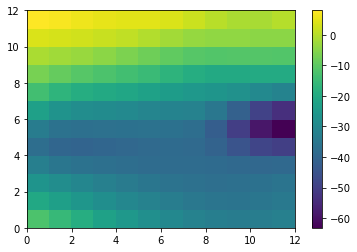

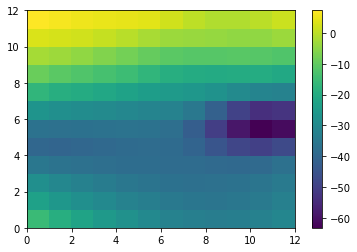

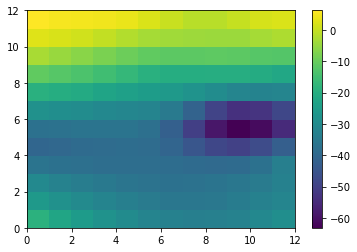

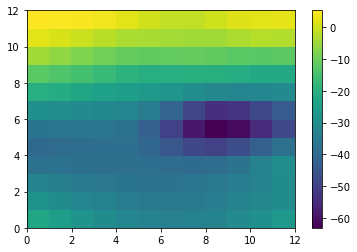

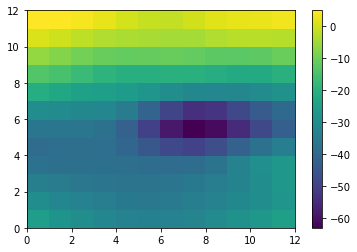

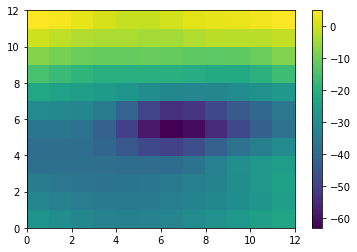

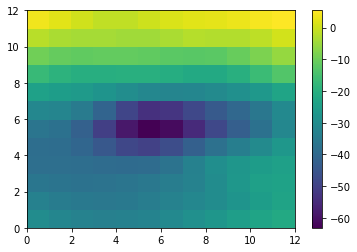

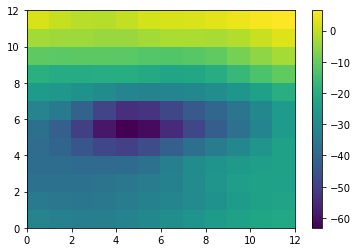

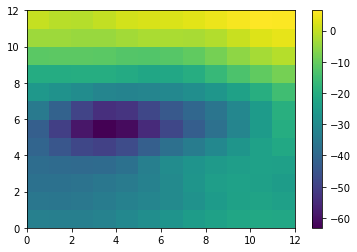

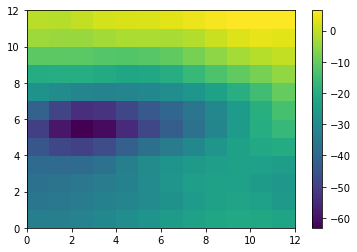

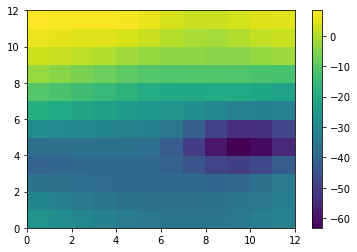

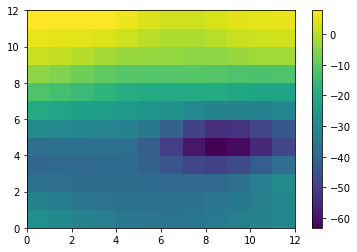

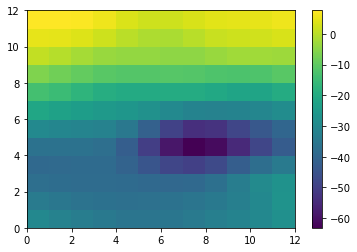

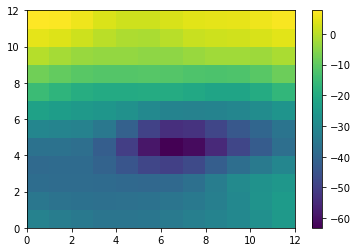

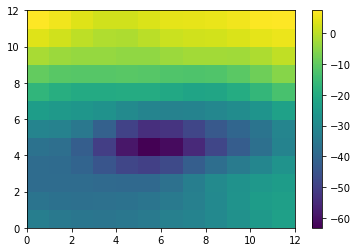

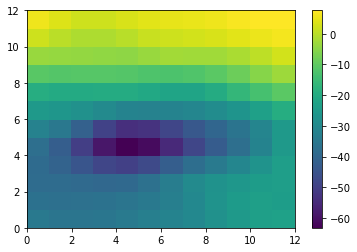

In [18]:
# Ici on plot les vignettes dont la prédictions a indiqué qu'elle contenait une tempête 

for i in np.where(X_predic==1)[0]:
    plt.figure()
    plt.pcolormesh(X[i].reshape(2*dt,2*dt))
    plt.colorbar()